In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns

import lightgbm as lgb

In [2]:
df_f = pd.read_csv('/content/drive/MyDrive/walmart_recruiting/data/features.csv.zip')
df_st = pd.read_csv('/content/drive/MyDrive/walmart_recruiting/data/stores.csv')
df_train = pd.read_csv('/content/drive/MyDrive/walmart_recruiting/data/train.csv.zip')
df_test = pd.read_csv('/content/drive/MyDrive/walmart_recruiting/data/test.csv.zip')
df_sample = pd.read_csv('/content/drive/MyDrive/walmart_recruiting/data/sampleSubmission.csv.zip')

In [3]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [4]:
# ファイルをマージ
df_train = pd.merge(df_train, df_st, on='Store')

del df_f['IsHoliday'] # IsHolidayはfeatures.csvにもstores.csvにもあったので、片方は消しておく。
df_train = pd.merge(df_train, df_f, on=['Store', 'Date'])

In [5]:
# 日付を特徴量とする
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train['Month'] = df_train['Date'].dt.month
df_train['Day'] = df_train['Date'].dt.day

# Typeはカテゴリ値が入っている。学習に使えるように数値にするのもかねて、count_encodingする
df_train_type = df_train.groupby('Type').size().reset_index().rename(columns={0:'Type_count'})
df_train = pd.merge(df_train, df_train_type, on='Type')

In [6]:
# まずは最後の1年、その前の1年をvalとし、trainとvalの評価値を見てみる
time_for_fold = [(df_train['Date'].max() - relativedelta(years=2), df_train['Date'].max() - relativedelta(years=1)),
                 (df_train['Date'].max() - relativedelta(years=1), df_train['Date'].max())]
time_for_fold

[(Timestamp('2010-10-26 00:00:00'), Timestamp('2011-10-26 00:00:00')),
 (Timestamp('2011-10-26 00:00:00'), Timestamp('2012-10-26 00:00:00'))]

In [7]:
# とりあえずLightGBMにつっこんでみる。
# TODO: pureなmaeしか見ていないが、問題設定のようにHolidayのweightも反映させるべき。

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 40,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "mae"
}

categorical_features = ['Store', 'Dept']

models = []
for start_time, end_time in time_for_fold:
    print(f'val start_time: {start_time}, end_time: {end_time}')
    trn_data = df_train[~((df_train['Date'] >= start_time) & (df_train['Date'] <= end_time))]
    val_data = df_train[((df_train['Date'] >= start_time) & (df_train['Date'] <= end_time))]
    
    trn_l = trn_data[['Weekly_Sales']]
    trn_f = trn_data.drop(columns=['Weekly_Sales', 'Date', 'Type'])
    val_l = val_data[['Weekly_Sales']]
    val_f = val_data.drop(columns=['Weekly_Sales', 'Date', 'Type'])
    
    d_training = lgb.Dataset(trn_f, label=trn_l, 
                             categorical_feature=categorical_features, free_raw_data=False)
    d_val = lgb.Dataset(val_f, label=val_l, 
                        categorical_feature=categorical_features, free_raw_data=False)

    model = lgb.train(params,
                      train_set=d_training,
                      num_boost_round=5000,
                      valid_sets=[d_training, d_val],
                      verbose_eval=200,
                      early_stopping_rounds=200)

    models.append(model)

val start_time: 2010-10-26 00:00:00, end_time: 2011-10-26 00:00:00


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[200]	training's l1: 2600.73	valid_1's l1: 2971.74
[400]	training's l1: 2019.06	valid_1's l1: 2502.59
[600]	training's l1: 1749.17	valid_1's l1: 2334.11
[800]	training's l1: 1598.58	valid_1's l1: 2247.53
[1000]	training's l1: 1488.76	valid_1's l1: 2189.04
[1200]	training's l1: 1416.8	valid_1's l1: 2160.08
[1400]	training's l1: 1357.55	valid_1's l1: 2126.68
[1600]	training's l1: 1306.41	valid_1's l1: 2105.84
[1800]	training's l1: 1261.51	valid_1's l1: 2086.75
[2000]	training's l1: 1223.33	valid_1's l1: 2072.86
[2200]	training's l1: 1187.24	valid_1's l1: 2063.66
[2400]	training's l1: 1159.48	valid_1's l1: 2057.64
[2600]	training's l1: 1129.4	valid_1's l1: 2050.53
[2800]	training's l1: 1101.71	valid_1's l1: 2039.83
[3000]	training's l1: 1074.97	valid_1's l1: 2028.67
[3200]	training's l1: 1055.19	valid_1's l1: 2025.75
[3400]	training's l1: 1037.07	valid_1's l1: 2020.94
[3600]	training's l1: 1017.51	valid_1's l1: 2015.47
[3800]	

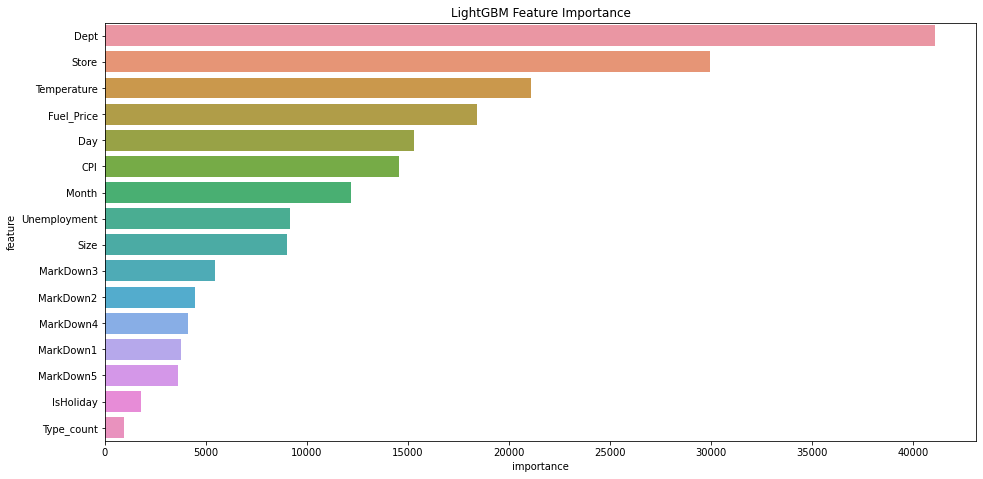

In [8]:
df_fimp = pd.DataFrame()
df_fimp["feature"] = trn_f.columns.values
df_fimp["importance"] = models[0].feature_importance() / len(models)
df_fimp["importance"] += models[1].feature_importance() / len(models)

plt.figure(figsize=(14, 7))
sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
plt.title("LightGBM Feature Importance")
plt.rcParams["font.size"] = 18
plt.tight_layout()


中盤の1年間と最後の1年間で、valの値が大きく変わらない。
- これらをvalとして、CV値として評価できそう。
- 本当はn等分に分割したいが、EDAから日付が重要そうなので、valの期間は1年使うべきかもしれない。
- TODO: 半年単位にしたら問題が起きるか、検証する

学習の方針:
- 今回は全Dept, Storeをごちゃまぜで学習させたが、1model/1Deptでもよいかもしれない。
- EDAから、Type:Cのみ特殊な変化をしていたので、Typeも分割できる？
- 以下の複数の分割の方法でmodelを作り、アンサンブルするのもよさそう。
  - 1model/全Dept (このbaseline)
  - 1model/1Dept
  - 1model/1Dept・1Type (Dept:1・Type:Aのみ, Dept:1・Type:Bのみ, Dept:1・Type:Cのみ...と作っていく)

特徴量:
- target encoding
  - targetのmax, min, mean
- ピークになる日付がmodelから分かりやすいような特徴量
  - 日付のtarget_encoding
- tsfreshによる特徴量作成
- phophetでtrendの変化を見る

model:
- LSTM
- 1DCNN
- TabNet
- (transformer的な手法？)
- これらのensemble